In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

Read in data.

In [2]:
ori_DNA_rep1 = pd.read_csv('counts_20230704/STARR_DNA_rep1_counts.txt', sep='\t', names=['sequence', 'count'])
ori_DNA_rep2 = pd.read_csv('counts_20230704/STARR_DNA_rep2_counts.txt', sep='\t', names=['sequence', 'count'])
ori_RNA_rep1 = pd.read_csv('counts_20230704/STARR_RNA_rep1_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])
ori_RNA_rep2 = pd.read_csv('counts_20230704/STARR_RNA_rep2_counts.txt', sep='\t', names=['sequence', 'count', 'collapsed_count'])

Join RNA and DNA on sequences.

In [3]:
joined_DNA = ori_DNA_rep1.merge(ori_DNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_RNA = ori_RNA_rep1.merge(ori_RNA_rep2, on='sequence', how='inner', suffixes=('_rep1', '_rep2'))
joined_counts = joined_DNA.merge(joined_RNA, on='sequence', how='inner', suffixes=('_DNA', '_RNA'))

Calculate average DNA counts normalized to total DNA reads per sample, then normalize RNA counts by average DNA count.

In [4]:
joined_counts['cpm_DNA_1'] = (joined_counts['count_rep1_DNA']/joined_counts['count_rep1_DNA'].sum()) * 1e6
joined_counts['cpm_DNA_2'] = (joined_counts['count_rep2_DNA']/joined_counts['count_rep2_DNA'].sum()) * 1e6
joined_counts['avg_cpm_DNA'] = (joined_counts['cpm_DNA_1'] + joined_counts['cpm_DNA_2']) / 2
joined_counts['RNA_rep1_norm'] = joined_counts['collapsed_count_rep1'] / joined_counts['avg_cpm_DNA']
joined_counts['RNA_rep2_norm'] = joined_counts['collapsed_count_rep2'] / joined_counts['avg_cpm_DNA']
joined_counts.head()

,sequence,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,avg_cpm_DNA,RNA_rep1_norm,RNA_rep2_norm
0,GGTGTCGTGGTCGGTACAGGACTGTAAGGGTTGCGGTACTTCAGTG...,445,1012,1846,131,1011,82,27.385596,38.554655,32.970125,3.973294,2.487100
1,AATGTTTTAGGCCAGTGCCATGGGGTATGAAGTGAGGGGAATTGGG...,424,614,4147,268,1982,167,26.093242,23.391856,24.742549,10.831544,6.749507
2,GTGGCACGTGTGTGATGGGGTACATTAGTCACTTGAGGCCTGAAGA...,423,706,536,52,1701,150,26.031702,26.896824,26.464263,1.964914,5.668021
3,AGGGGGTGGTACACTGTTTTAAGAAGCCCTGGGCAATTGTCTGACT...,422,791,2502,202,809,79,25.970161,30.135110,28.052636,7.200749,2.816135
4,ATGTTCCACAGGATGTGGGTGCTGGGTGGTTCAGTTTGAGGCGATG...,416,822,1671,122,1967,142,25.600917,31.316132,28.458525,4.286940,4.989718


In [5]:
joined_counts.describe()

,count_rep1_DNA,count_rep2_DNA,count_rep1_RNA,collapsed_count_rep1,count_rep2_RNA,collapsed_count_rep2,cpm_DNA_1,cpm_DNA_2,avg_cpm_DNA,RNA_rep1_norm,RNA_rep2_norm
count,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000,358837.000000
mean,45.283563,73.148678,321.637133,26.572168,308.532632,26.698141,2.786781,2.786781,2.786781,12.559725,11.345519
std,29.102870,48.418631,367.016176,27.046461,293.017864,23.188531,1.791010,1.844628,1.784357,18.931608,11.813248
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.061541,0.038097,0.049819,0.055033,0.068049
25%,25.000000,40.000000,17.000000,4.000000,113.000000,10.000000,1.538517,1.523899,1.561978,1.991637,4.606091
50%,40.000000,63.000000,255.000000,21.000000,235.000000,21.000000,2.461627,2.400142,2.429422,7.851422,8.777727
75%,59.000000,94.000000,465.000000,38.000000,431.000000,37.000000,3.630899,3.581164,3.579665,16.417830,14.660930
max,445.000000,1012.000000,7680.000000,492.000000,10461.000000,649.000000,27.385596,38.554655,32.970125,1324.793761,983.559004


Look at correlation between replicates after normalization.

<AxesSubplot:xlabel='RNA_rep1_norm', ylabel='RNA_rep2_norm'>

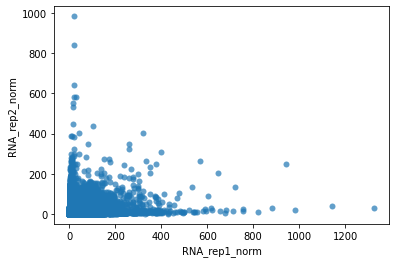

In [6]:
sns.scatterplot(data=joined_counts, x='RNA_rep1_norm', y='RNA_rep2_norm', linewidth=0, alpha=0.7)

In [7]:
stats.pearsonr(joined_counts['RNA_rep1_norm'], joined_counts['RNA_rep2_norm'])

(0.12387150324411525, 0.0)

See if spike-in sequences are present.

In [8]:
spike_in = pd.read_csv('opoolsentry_spike_in.csv', names=['pool', 'sequence'])
spike_in['sequence'] = spike_in['sequence'].str.upper()
# remove adapter sequences
spike_in_seqs = [seq[33:133] for seq in spike_in['sequence']]
spike_in_seqs = set(spike_in_seqs)

In [9]:
joined_counts['spike_in'] = joined_counts['sequence'].isin(spike_in_seqs)
sum(joined_counts['spike_in'])

9

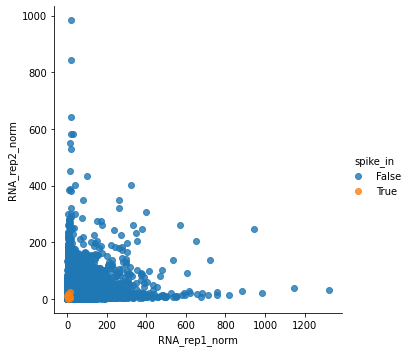

In [10]:
sns.lmplot(data=joined_counts, x="RNA_rep1_norm", y="RNA_rep2_norm", fit_reg=False, hue='spike_in')

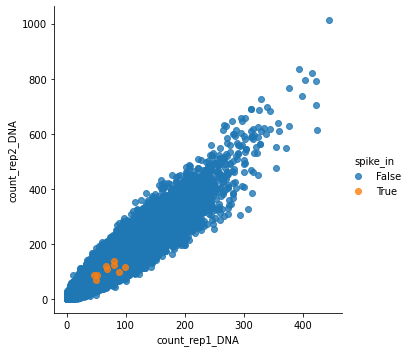

In [11]:
sns.lmplot(data=joined_counts, x="count_rep1_DNA", y="count_rep2_DNA", fit_reg=False, hue='spike_in')

Look for instances of motif in sequences

In [12]:
joined_counts['motif'] = joined_counts['sequence'].str.contains(r'[ACG]ATTT[AG]CAT[ACG]ACAAT[AG][ACG]')

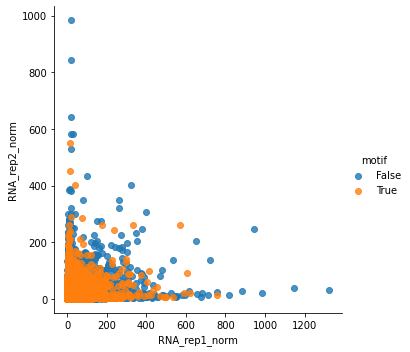

In [13]:
sns.lmplot(data=joined_counts, x="RNA_rep1_norm", y="RNA_rep2_norm", fit_reg=False, hue='motif')

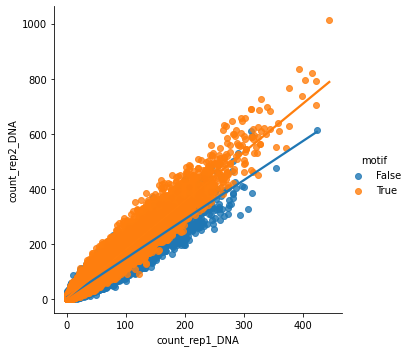

In [14]:
sns.lmplot(data=joined_counts, x="count_rep1_DNA", y="count_rep2_DNA", fit_reg=True, hue='motif')

Add GC content column.

In [15]:
def GC_content(seq):
    return sum(base == 'G' or base == 'C' for base in seq) / len(seq)
assert GC_content('ATATATCGAT') == 0.2
assert GC_content('CGGCGTATAT') == 0.5

In [16]:
joined_counts['GC'] = joined_counts['sequence'].apply(GC_content)

Look at correlation between GC content and expression.

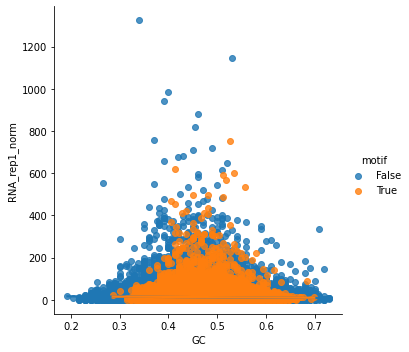

In [17]:
sns.lmplot(data=joined_counts, x="GC", y="RNA_rep1_norm", fit_reg=True, hue='motif')

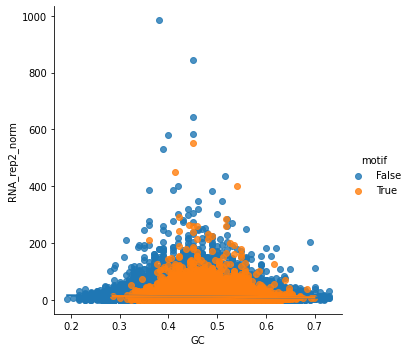

In [18]:
sns.lmplot(data=joined_counts, x="GC", y="RNA_rep2_norm", fit_reg=True, hue='motif')

Filter out sequences with low RNA counts.

In [19]:
RNA_threshold = 20
DNA_threshold = 0
joined_counts_filtered = joined_counts.loc[(joined_counts['collapsed_count_rep1'] > RNA_threshold)
                                   & (joined_counts['collapsed_count_rep2'] > RNA_threshold)
                                   & (joined_counts['avg_cpm_DNA'] > DNA_threshold)]
len(joined_counts_filtered)

100218

<AxesSubplot:xlabel='RNA_rep1_norm', ylabel='RNA_rep2_norm'>

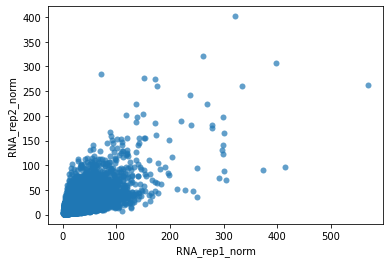

In [20]:
sns.scatterplot(data=joined_counts_filtered, x='RNA_rep1_norm', y='RNA_rep2_norm', linewidth=0, alpha=0.7)

In [21]:
stats.pearsonr(joined_counts_filtered['RNA_rep1_norm'], joined_counts_filtered['RNA_rep2_norm'])

(0.5825647470581456, 0.0)

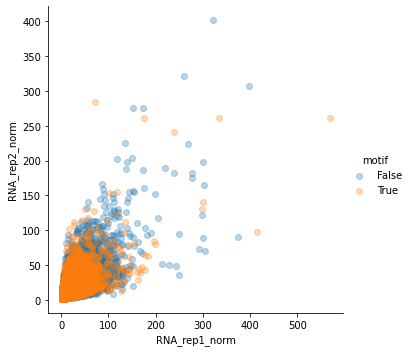

In [22]:
sns.lmplot(data=joined_counts_filtered, x="RNA_rep1_norm", y="RNA_rep2_norm", fit_reg=False, hue='motif', scatter_kws={'alpha':0.3})

In [23]:
joined_counts.groupby('motif')[['RNA_rep1_norm', 'RNA_rep2_norm']].describe()

RNA_rep1_norm                                                      \
              count       mean        std       min       25%       50%   
motif                                                                     
False      306908.0  12.503328  18.602678  0.055033  1.924617  7.851263   
True        51929.0  12.893042  20.766599  0.059180  2.441744  7.852671   

                              RNA_rep2_norm                                  \
             75%          max         count       mean        std       min   
motif                                                                         
False  16.478143  1324.793761      306908.0  11.381992  11.728864  0.080442   
True   16.076592   755.069666       51929.0  11.129958  12.298068  0.068049   

                                                  
            25%       50%        75%         max  
motif                                             
False  4.642645  8.856843  14.753495  983.559004  
True   4.410128  8.322792  14.076451  551.781679

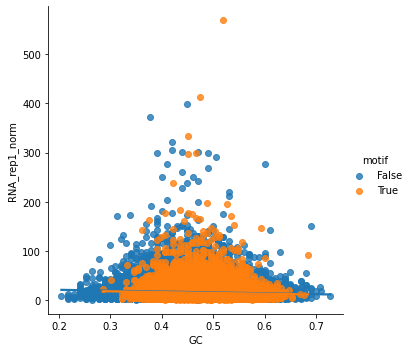

In [24]:
sns.lmplot(data=joined_counts_filtered, x="GC", y="RNA_rep1_norm", fit_reg=True, hue='motif')

In [25]:
stats.pearsonr(joined_counts_filtered['RNA_rep1_norm'], joined_counts_filtered['GC'])

(-0.0770699236058336, 7.401484704318803e-132)